In [1]:
!pip install datasets
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 452.9/452.9 KB 10.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 213.0/213.0 KB 25.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 132.0/132.0 KB 16.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 182.4/182.4 KB 15.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 140.6/140.6 KB 20.3 MB/s eta 0:00:00
  Attempting uninstall: urllib3
    Found existing installation: urllib3 1.24.3
    Uninstalling urllib3-1.24.3:
      Successfully uninstalled urllib3-1.24.3
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.8/5.8 MB 51.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 105.7 MB/s eta 0:00:00


In [1]:
import re
import string
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report,accuracy_score,precision_score,recall_score,f1_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold, cross_val_score
from sklearn.utils.class_weight import compute_class_weight
import random
import torch
import torch.nn as nn
import datasets
from datasets import load_dataset,DatasetDict
from transformers import AutoTokenizer,TFAutoModelForSequenceClassification, AutoModel, DataCollatorWithPadding, AutoModelForSequenceClassification, AutoConfig
from transformers import TrainingArguments, Trainer, AutoModelForPreTraining
import time
import copy
from tqdm.auto import tqdm

In [2]:
dml = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
dml

device(type='cpu')

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
class_name = {0: 'Acne',
             1: 'Back pain',
             2: 'Blurry vision',
             3: 'Body feels weak',
             4: 'Cough',
             5: 'Ear ache',
             6: 'Emotional pain',
             7: 'Feeling cold',
             8: 'Feeling dizzy',
             9: 'Foot ache',
             10: 'Hair falling out',
             11: 'Hard to breath',
             12: 'Head ache',
             13: 'Heart hurts',
             14: 'Infected wound',
             15: 'Injury from sports',
             16: 'Internal pain',
             17: 'Joint pain',
             18: 'Knee pain',
             19: 'Muscle pain',
             20: 'Neck pain',
             21: 'Open wound',
             22: 'Shoulder pain',
             23: 'Skin issue',
             24: 'Stomach ache'}

classes = [class_name[x] for x in class_name]

# For AMD

In [45]:
import torch_directml
dml = torch_directml.device()
dml

device(type='privateuseone', index=0)

# Read data from file 

In [4]:
PATH = 'dataset.csv'
dataSet = pd.read_csv(PATH)
print(dataSet.shape)
dataSet.head(10)

(1711, 2)


,Phrase,Prompt
0,আমার শ্বাস নিতে কষ্ট হচ্ছে- আমার কি হার্ট অ্যা...,Hard to breath
1,আমি নিজেকে আঘাত করেছি এবং ক্ষতটা নিরাময় হতে চ...,Open wound
2,আমার মেয়ের ভ্রু সগুণ ছিল এবং এটি তার একটি ভ্র...,Infected wound
3,যখন আমি খুব দ্রুত উঠে দাঁড়াই তখন আমার মাথা ঘো...,Feeling dizzy
4,অ্যাপেনডিসাইটিসের লক্ষণগুলো কী কী?,Internal pain
5,মনে হচ্ছে কেউ আমার কাঁধে ছুরি দিয়ে আঘাত করছে,Shoulder pain
6,"দাঁড়ানো কঠিন, এবং আমি খুব ধীরে ধীরে চলছি",Body feels weak
7,আমার এক ধরণের ক্রিম দরকার যা আমার পেশীগুলিকে আ...,Muscle pain
8,আমার শ্বাস নিতে সমস্যা হয় না কিন্তু শ্বাস বের...,Hard to breath
9,আমার শরীর মনে হচ্ছে এটি একটি রেফ্রিজারেটরে আছে.,Feeling cold


# Drop duplicate value

In [5]:
print(dataSet.shape)
dataSet = dataSet.drop_duplicates(subset=['Phrase'])
print(dataSet.shape)

(1711, 2)
(1710, 2)


In [6]:
dataSet = dataSet.reset_index()

# Preprocessing

In [7]:
def remove_urls(phrase):
    return re.sub(r"http(s?)://[\S]+", '', phrase)

def remove_at_links(phrase):
    return re.sub(r"\B(@)\S+", '', phrase)

def fix_special_chars(phrase):
    phrase = phrase.replace("&amp;", " ")
    phrase = phrase.replace("\n", " ")
    return phrase

def remove_emoji(phrase):
    emoji_pattern = re.compile("["
                               u"\U0001F600-\U0001F64F"  # emoticons
                               u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                               u"\U0001F680-\U0001F6FF"  # transport & map symbols
                               u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                               u"\U00002500-\U00002BEF"  # chinese char
                               u"\U00002702-\U000027B0"
                               u"\U00002702-\U000027B0"
                               u"\U000024C2-\U0001F251"
                               u"\U0001f926-\U0001f937"
                               u"\U00010000-\U0010ffff"
                               u"\u2640-\u2642"
                               u"\u2600-\u2B55"
                               u"\u200d"
                               u"\u23cf"
                               u"\u23e9"
                               u"\u231a"
                               u"\ufe0f"  # dingbats
                               u"\u3030"
                               "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', phrase)

def remove_punctuation(phrase):
    punc = '''!()-[]{};:'"\,<>./?@#$%^&*_~।,;:?!\'."-[]{}()–—―~'''
    for ele in phrase:
        if ele in punc:
            phrase = phrase.replace(ele, " ")
    return phrase

def clean_phrase(phrase):
    phrase = remove_punctuation(phrase)
    phrase = remove_urls(phrase)
    phrase = remove_at_links(phrase)
    phrase = fix_special_chars(phrase)
    phrase = remove_emoji(phrase)

    return phrase

In [8]:
lst = [clean_phrase(phrase) for phrase in dataSet['Phrase']]
dataSet['Phrase_cleaned'] = lst
dataSet.head()

,index,Phrase,Prompt,Phrase_cleaned
0,0,আমার শ্বাস নিতে কষ্ট হচ্ছে- আমার কি হার্ট অ্যা...,Hard to breath,আমার শ্বাস নিতে কষ্ট হচ্ছে আমার কি হার্ট অ্যা...
1,1,আমি নিজেকে আঘাত করেছি এবং ক্ষতটা নিরাময় হতে চ...,Open wound,আমি নিজেকে আঘাত করেছি এবং ক্ষতটা নিরাময় হতে চ...
2,2,আমার মেয়ের ভ্রু সগুণ ছিল এবং এটি তার একটি ভ্র...,Infected wound,আমার মেয়ের ভ্রু সগুণ ছিল এবং এটি তার একটি ভ্র...
3,3,যখন আমি খুব দ্রুত উঠে দাঁড়াই তখন আমার মাথা ঘো...,Feeling dizzy,যখন আমি খুব দ্রুত উঠে দাঁড়াই তখন আমার মাথা ঘো...
4,4,অ্যাপেনডিসাইটিসের লক্ষণগুলো কী কী?,Internal pain,অ্যাপেনডিসাইটিসের লক্ষণগুলো কী কী


# Adding class lavel in numeric value

In [9]:
dataSet['Label'] = pd.Categorical(dataSet['Prompt']).codes

In [10]:
dataSet.isnull().sum()

index             0
Phrase            0
Prompt            0
Phrase_cleaned    0
Label             0
dtype: int64

In [11]:
dataSet

,index,Phrase,Prompt,Phrase_cleaned,Label
0,0,আমার শ্বাস নিতে কষ্ট হচ্ছে- আমার কি হার্ট অ্যা...,Hard to breath,আমার শ্বাস নিতে কষ্ট হচ্ছে আমার কি হার্ট অ্যা...,11
1,1,আমি নিজেকে আঘাত করেছি এবং ক্ষতটা নিরাময় হতে চ...,Open wound,আমি নিজেকে আঘাত করেছি এবং ক্ষতটা নিরাময় হতে চ...,21
2,2,আমার মেয়ের ভ্রু সগুণ ছিল এবং এটি তার একটি ভ্র...,Infected wound,আমার মেয়ের ভ্রু সগুণ ছিল এবং এটি তার একটি ভ্র...,14
3,3,যখন আমি খুব দ্রুত উঠে দাঁড়াই তখন আমার মাথা ঘো...,Feeling dizzy,যখন আমি খুব দ্রুত উঠে দাঁড়াই তখন আমার মাথা ঘো...,8
4,4,অ্যাপেনডিসাইটিসের লক্ষণগুলো কী কী?,Internal pain,অ্যাপেনডিসাইটিসের লক্ষণগুলো কী কী,16
...,...,...,...,...,...
1705,1706,আমার মনে হচ্ছে আমার হাঁটুর পিছনে কিছু একটা ফোল...,Knee pain,আমার মনে হচ্ছে আমার হাঁটুর পিছনে কিছু একটা ফোল...,18
1706,1707,আমার ঘাড় আমাকে বিরক্ত করছে আমি এর কারণে ঘুমাত...,Neck pain,আমার ঘাড় আমাকে বিরক্ত করছে আমি এর কারণে ঘুমাত...,20
1707,1708,চুলের টনিক ব্যবহার করে,Hair falling out,চুলের টনিক ব্যবহার করে,10
1708,1709,"আপনি আমাকে বিশ্বাস করবেন না, কিন্তু আমার হাতের...",Infected wound,আপনি আমাকে বিশ্বাস করবেন না কিন্তু আমার হাতের...,14


# Dataset statistics

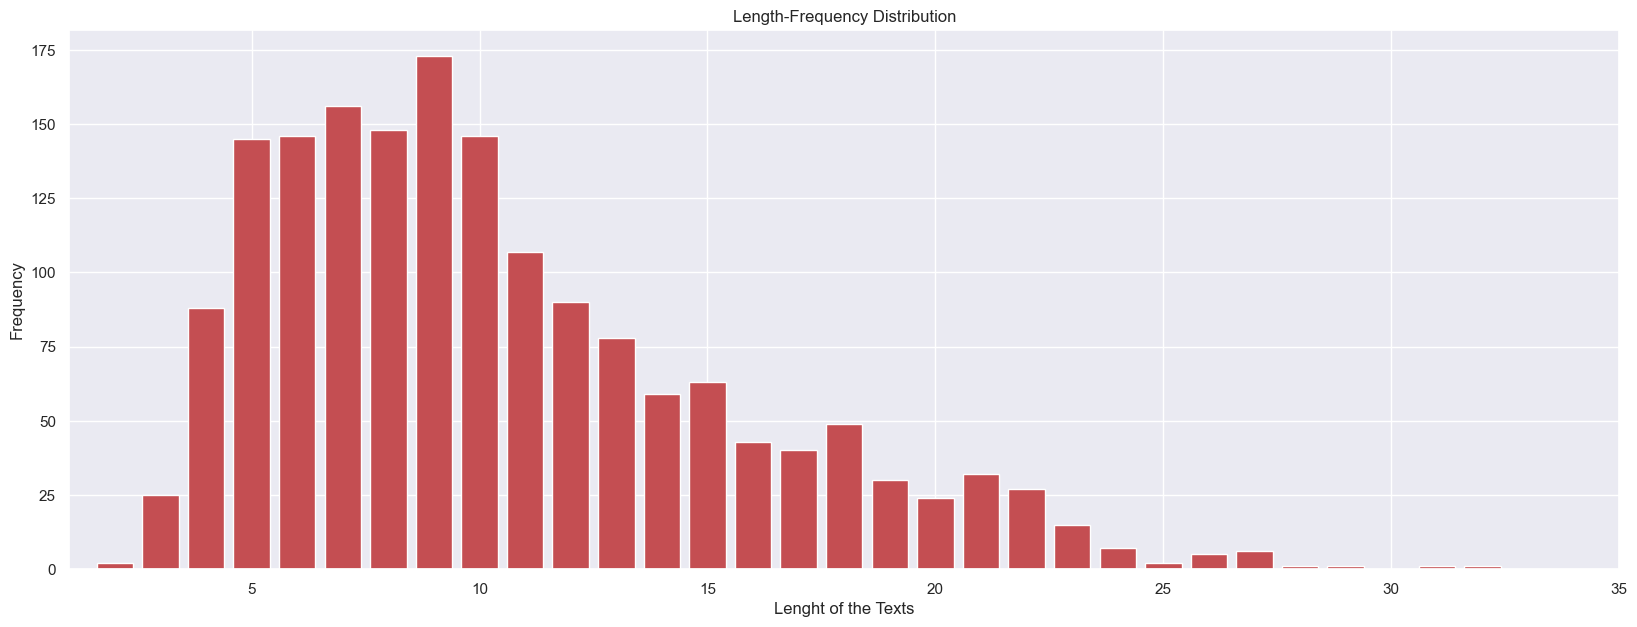

Maximum Length of a phrase: 32
Minimum Length of a phrase: 2
Average Length of a phrase: 10.0


In [12]:
# Calculate the Review of each of the Review
dataSet['Phrase_length'] = dataSet.Phrase_cleaned.apply(lambda x:len(x.split()))

total_words = 0

frequency = dict()
for i in dataSet.Phrase_length:
    frequency[i] = frequency.get(i, 0)+1

sns.set(rc={'figure.figsize':(20, 7)})
plt.bar(frequency.keys(), frequency.values(), color ="r")
plt.xlim(1, 35)
plt.xlabel('Lenght of the Texts')
plt.ylabel('Frequency')
plt.title('Length-Frequency Distribution')
plt.show()  

print(f"Maximum Length of a phrase: {max(dataSet.Phrase_length)}")
print(f"Minimum Length of a phrase: {min(dataSet.Phrase_length)}")
print(f"Average Length of a phrase: {round(np.mean(dataSet.Phrase_length), 0)}")

In [13]:
all_words = []
for sentence in dataSet.Phrase_cleaned.apply(lambda x: x.split()):
    for word in sentence:
        all_words.append(word)

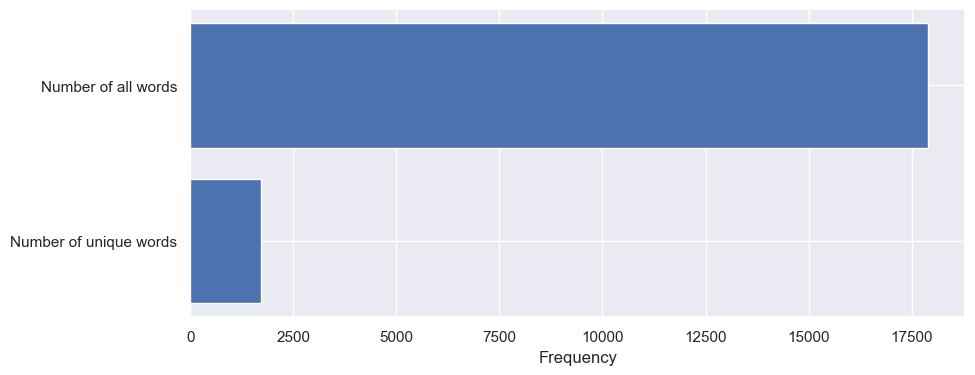

Total number of words:  17908
Total number of unique words:  1708


In [14]:
freq_words = len(all_words)
freq_unique_words = len(set(all_words))

plt.figure(figsize = (10, 4))
plt.barh(['Number of unique words', 'Number of all words'], [freq_unique_words, freq_words])
plt.xlabel("Frequency")
plt.show()
print("Total number of words: ", freq_words)
print("Total number of unique words: ", freq_unique_words)

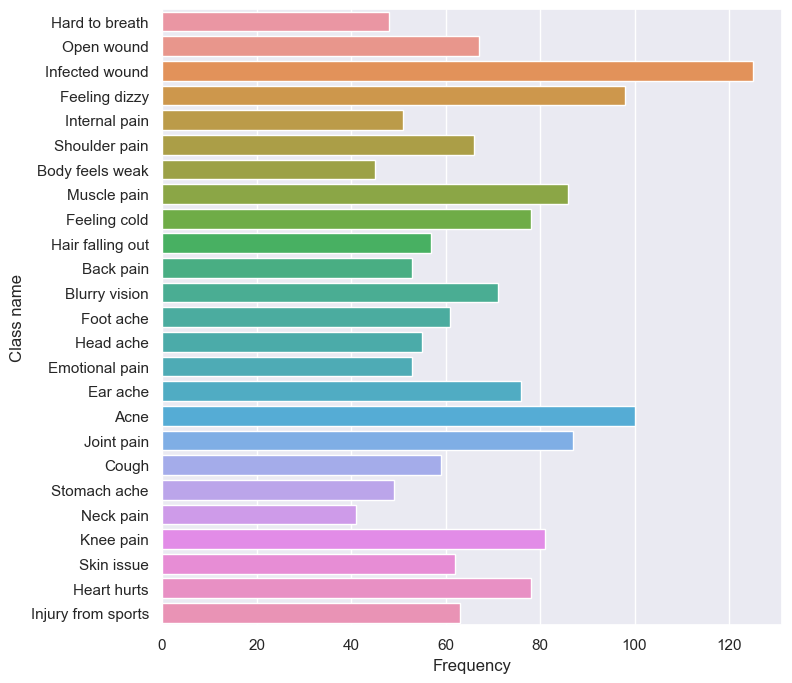

In [15]:
sns.set_style("whitegrid")
sns.set(rc={'figure.figsize':(8, 8)})
promptsPlot = sns.countplot(y=dataSet['Prompt'], data=dataSet)
# promptsPlot.bar_label(promptsPlot.containers[0])
promptsPlot.set(xlabel='Frequency', ylabel='Class name')
plt.show()

# Dropping unnecessary columns

In [16]:
dataSet = dataSet.drop(['Phrase', 'Phrase_length'], axis=1)
dataSet

,index,Prompt,Phrase_cleaned,Label
0,0,Hard to breath,আমার শ্বাস নিতে কষ্ট হচ্ছে আমার কি হার্ট অ্যা...,11
1,1,Open wound,আমি নিজেকে আঘাত করেছি এবং ক্ষতটা নিরাময় হতে চ...,21
2,2,Infected wound,আমার মেয়ের ভ্রু সগুণ ছিল এবং এটি তার একটি ভ্র...,14
3,3,Feeling dizzy,যখন আমি খুব দ্রুত উঠে দাঁড়াই তখন আমার মাথা ঘো...,8
4,4,Internal pain,অ্যাপেনডিসাইটিসের লক্ষণগুলো কী কী,16
...,...,...,...,...
1705,1706,Knee pain,আমার মনে হচ্ছে আমার হাঁটুর পিছনে কিছু একটা ফোল...,18
1706,1707,Neck pain,আমার ঘাড় আমাকে বিরক্ত করছে আমি এর কারণে ঘুমাত...,20
1707,1708,Hair falling out,চুলের টনিক ব্যবহার করে,10
1708,1709,Infected wound,আপনি আমাকে বিশ্বাস করবেন না কিন্তু আমার হাতের...,14


# Splitting dataset into train, test and valid

In [17]:
X = dataSet['Phrase_cleaned']
Y = dataSet['Label']

In [18]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.15, random_state=1, stratify=Y)
# X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size=0.10, random_state=1, stratify=Y_train)

In [19]:
print(X_train.shape)
print(X_test.shape)
# print(X_val.shape)

print(Y_train.value_counts(normalize=True)*100)
# print(Y_val.value_counts(normalize=True)*100)
print(Y_test.value_counts(normalize=True)*100)

(1453,)
(257,)
14    7.295251
0     5.849966
8     5.712319
17    5.092911
19    5.024088
18    4.748796
7     4.542326
13    4.542326
5     4.473503
2     4.129387
21    3.922918
22    3.854095
15    3.716449
23    3.647626
9     3.578802
4     3.441156
10    3.303510
12    3.234687
1     3.097041
6     3.097041
16    2.959394
24    2.890571
11    2.821748
3     2.615279
20    2.408809
Name: Label, dtype: float64
14    7.392996
8     5.836576
0     5.836576
19    5.058366
17    5.058366
7     4.669261
18    4.669261
13    4.669261
2     4.280156
5     4.280156
22    3.891051
21    3.891051
23    3.501946
10    3.501946
9     3.501946
15    3.501946
4     3.501946
16    3.112840
1     3.112840
12    3.112840
6     3.112840
11    2.723735
3     2.723735
24    2.723735
20    2.334630
Name: Label, dtype: float64


In [20]:
train_df = pd.DataFrame({"Post_cleaned": list(X_train), "Type": list(Y_train)})
test_df = pd.DataFrame({"Post_cleaned": list(X_test), "Type": list(Y_test)})
# validation_df = pd.DataFrame({"Post_cleaned": list(X_val), "Type": list(Y_val)})

ds = DatasetDict()

ds['train'] = datasets.Dataset.from_pandas(train_df)
ds['test'] = datasets.Dataset.from_pandas(test_df)
# ds['validation'] = datasets.Dataset.from_pandas(validation_df)

print(ds)

DatasetDict({
    train: Dataset({
        features: ['Post_cleaned', 'Type'],
        num_rows: 1453
    })
    test: Dataset({
        features: ['Post_cleaned', 'Type'],
        num_rows: 257
    })
})


# Loading the pretrained model

In [21]:
# checkpoint = 'neuralspace-reverie/indic-transformers-bn-bert'
checkpoint = 'csebuetnlp/banglabert'
# checkpoint = 'sagorsarker/bangla-bert-base'
tokenizer = AutoTokenizer.from_pretrained(checkpoint)
# tokenizer.model_max_len = 300
sequence = "আপনি কেমন আছেন?"
tokens = tokenizer.tokenize(sequence)
ids = tokenizer.convert_tokens_to_ids(tokens)

In [22]:
print(f"Vocab size is : {tokenizer.vocab_size}")

print(f"Model max length is : {tokenizer.model_max_length}")

print(f"Model input names are: {tokenizer.model_input_names}")

Vocab size is : 32000
Model max length is : 1000000000000000019884624838656
Model input names are: ['input_ids', 'token_type_ids', 'attention_mask']


# Tokenize each post

In [23]:
def tokenize_function(train_dataset):
    return tokenizer(train_dataset['Post_cleaned'], padding=True, truncation=True, max_length=50)

tokenized_dataset = ds.map(tokenize_function, batched=True)

tokenized_dataset

  0%|          | 0/2 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

DatasetDict({
    train: Dataset({
        features: ['Post_cleaned', 'Type', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 1453
    })
    test: Dataset({
        features: ['Post_cleaned', 'Type', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 257
    })
})

In [24]:
tokenized_dataset.set_format('torch', columns=["input_ids", "attention_mask", "Type"])
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

# Split dataset into batches

In [25]:
from torch.utils.data import DataLoader

train_loader = DataLoader(
    tokenized_dataset['train'], shuffle = True, batch_size = 16, collate_fn = data_collator
)

test_loader = DataLoader(
    tokenized_dataset["test"], batch_size=1, collate_fn=data_collator
)

# validation_loader = DataLoader(
#     tokenized_dataset['validation'], shuffle = True, batch_size = 1, collate_fn = data_collator
# )

# Creating the dictionary of train and validation dataset

In [26]:
dataloaders = {"train" : train_loader,
               "val" : test_loader}

# Model initialization

In [27]:
class MyTaskSpecificCustomModel(nn.Module):
    def __init__(self, checkpoint, num_labels):
        super(MyTaskSpecificCustomModel, self).__init__()
        self.num_labels = num_labels
        
        self.model = AutoModel.from_pretrained(checkpoint, config = AutoConfig.from_pretrained(checkpoint, 
                                                                                                       output_attention = True, 
                                                                                                       output_hidden_state = True))
        
        # print('Freezing BERT layers')
        # for _ , param in self.model.named_parameters():
        #     param.requires_grad=False
            
        self.dropout = nn.Dropout(0.1)

        # New Layer
        #layer 1
        self.activation1 = nn.ReLU()
        self.l1 = nn.Linear(768, 500)

        #layer 2
        self.l2 = nn.Linear(500, 256)
        self.activation2 = nn.ReLU()

        #layer 3
        self.l3 = nn.Linear(256, 128)
        self.activation3 = nn.ReLU()


        #Output layer 
        self.last = nn.Linear(128, num_labels)
        
    def forward(self, input_ids = None, attention_mask=None, Type = None):
        outputs = self.model(input_ids = input_ids, attention_mask = attention_mask)
        last_hidden_state = outputs[0]       
        sequence_outputs = self.dropout(last_hidden_state)

        #layer 1
        logits = self.l1(sequence_outputs[:, 0, : ].view(-1, 768))
        logits = self.activation1(logits)

        #layer 2
        logits = self.l2(logits)
        logits = self.activation2(logits)

        #layer 3
        logits = self.l3(logits)
        logits = self.activation3(logits)

        #output layer
        logits = self.last(logits)

        return logits       

In [28]:
base_model = MyTaskSpecificCustomModel(checkpoint=checkpoint, num_labels=25).to(dml)
base_model

Some weights of the model checkpoint at csebuetnlp/banglabert were not used when initializing ElectraModel: ['discriminator_predictions.dense_prediction.bias', 'discriminator_predictions.dense.bias', 'discriminator_predictions.dense_prediction.weight', 'discriminator_predictions.dense.weight']
- This IS expected if you are initializing ElectraModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing ElectraModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


MyTaskSpecificCustomModel(
  (model): ElectraModel(
    (embeddings): ElectraEmbeddings(
      (word_embeddings): Embedding(32000, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): ElectraEncoder(
      (layer): ModuleList(
        (0): ElectraLayer(
          (attention): ElectraAttention(
            (self): ElectraSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): ElectraSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), 

# Defining Hyperparameter

In [29]:
num_classes = 2
num_epochs = 40
learning_rate = 1e-5
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(base_model.parameters(), lr=learning_rate)

# Training the model

In [30]:
validation_loss = []
training_loss = []

def train_model():
    since = time.time()
    val_acc_history = []
    
    best_model_wts = copy.deepcopy(base_model.state_dict())
    best_acc = 0.0
    
    progress_bar_train = tqdm(range(num_epochs * len(train_loader)))
    progress_bar_eval = tqdm(range(num_epochs * len(test_loader)))
    
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)
        
        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                base_model.train()  # Set model to training mode
            else:
                base_model.eval()   # Set model to evaluate mode
                
            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for batch in dataloaders[phase]:
                batch = {k: v.to(dml) for k, v in batch.items()}
                
                # zero the parameter gradients
                optimizer.zero_grad()
                
                with torch.set_grad_enabled(phase == 'train'): 
                    outputs = base_model(**batch)
                    labels = batch['Type']
                    
                    loss = criterion(outputs, labels)

                    _, preds = torch.max(outputs, 1)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                        progress_bar_train.update(1)
                    elif phase == 'val':
                        progress_bar_eval.update(1)
                        
                running_loss += loss.item() * len(labels)
                preds = preds.cpu()
                labels = labels.data.cpu()
                running_corrects += (preds == labels).sum()
            
            print("Lenght: ", len(dataloaders[phase].dataset))
            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = float(running_corrects) / len(dataloaders[phase].dataset)

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

            if phase == 'train':
                training_loss.append(epoch_loss)
            elif phase == 'val':
                validation_loss.append(epoch_loss)
            
            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(base_model.state_dict())
            if phase == 'val':
                val_acc_history.append(epoch_acc)

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    base_model.load_state_dict(best_model_wts)
    return base_model, val_acc_history

In [ ]:
best_model, validation_acc_hist = train_model()

  0%|          | 0/3640 [00:00<?, ?it/s]

  0%|          | 0/10280 [00:00<?, ?it/s]

You're using a ElectraTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Epoch 0/39
----------
Lenght:  1453
train Loss: 3.2202 Acc: 0.0427
Lenght:  257
val Loss: 3.2104 Acc: 0.0700

Epoch 1/39
----------
Lenght:  1453
train Loss: 3.2002 Acc: 0.1211
Lenght:  257
val Loss: 3.1745 Acc: 0.2412

Epoch 2/39
----------
Lenght:  1453
train Loss: 3.1345 Acc: 0.2010
Lenght:  257
val Loss: 3.0606 Acc: 0.1751

Epoch 3/39
----------
Lenght:  1453
train Loss: 2.9900 Acc: 0.2154
Lenght:  257
val Loss: 2.8827 Acc: 0.2374

Epoch 4/39
----------


In [34]:
best_model = base_model

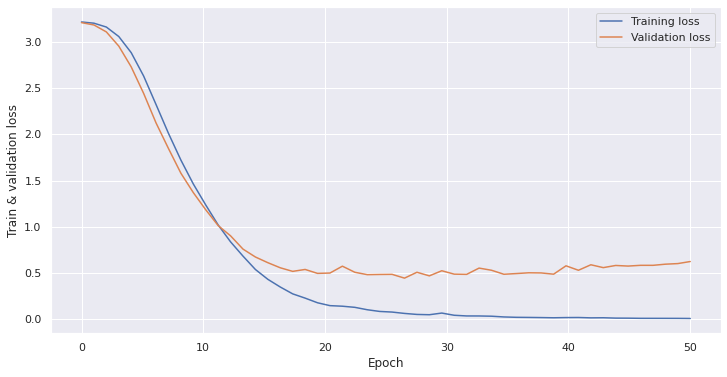

In [35]:
x = torch.linspace(0, num_epochs, num_epochs)
plt.figure(figsize=(12,6))
plt.plot(x, training_loss)
plt.plot(x, validation_loss)
plt.legend(['Training loss','Validation loss'])
plt.xlabel("Epoch")
plt.ylabel("Train & validation loss")
plt.show()

In [36]:
model_path = '/content/drive/MyDrive/Research Work/buet_bert.pt'
torch.save(best_model.state_dict(), model_path)

# Loading the saved model

In [37]:
best_model.load_state_dict(torch.load(model_path))

<All keys matched successfully>

# Testing the model using test dataset

In [38]:
def get_predictions():
    best_model.eval()
    predictions = []
    real_values = []
    with torch.no_grad():
        for batch in test_loader:
            batch = {k: v.to(dml) for k, v in batch.items()}
            
            outputs = base_model(**batch)
            labels = batch['Type']
            
            _, preds = torch.max(outputs, dim = 1)
            preds = preds.cpu()
            labels = labels.cpu()
            predictions.extend(preds)
            real_values.extend(labels)
            
    return predictions, real_values

In [39]:
pred, real = get_predictions()
print(classification_report([y_actual.item() for y_actual in real], [y_pred.item() for y_pred in pred], target_names=classes))

                    precision    recall  f1-score   support

              Acne       1.00      1.00      1.00        15
         Back pain       0.71      0.62      0.67         8
     Blurry vision       1.00      1.00      1.00        11
   Body feels weak       1.00      0.86      0.92         7
             Cough       0.90      1.00      0.95         9
          Ear ache       1.00      1.00      1.00        11
    Emotional pain       1.00      1.00      1.00         8
      Feeling cold       1.00      1.00      1.00        12
     Feeling dizzy       1.00      1.00      1.00        15
         Foot ache       0.90      1.00      0.95         9
  Hair falling out       1.00      0.89      0.94         9
    Hard to breath       1.00      1.00      1.00         7
         Head ache       0.89      1.00      0.94         8
       Heart hurts       0.83      0.83      0.83        12
    Infected wound       0.94      0.79      0.86        19
Injury from sports       0.89      0.89

In [40]:
def score_in_details():
    y_pred = [y.item() for y in pred]
    y_real = [y.item() for y in real]

    accuracy = accuracy_score(y_real, y_pred)
    precision = precision_score(y_real, y_pred, average='weighted')
    recall = recall_score(y_real, y_pred, average='weighted')
    f1 = f1_score(y_real, y_pred, average='weighted')

    print(f"Accuracy: {round(accuracy * 100, 2)}%")
    print(f"Precision: {round(precision * 100, 2)}%")
    print(f"Recall: {round(recall * 100, 2)}%")
    print(f"F1-score: {round(f1 * 100, 2)}%")
  
    print()
    print()

    conf_matrix = confusion_matrix(y_real, y_pred)

    fig, ax = plt.subplots(figsize=(15,15))
    sns.heatmap(pd.DataFrame(conf_matrix), annot = True, cmap = 'YlGnBu',fmt = 'g', xticklabels=classes, yticklabels=classes)
    plt.title('Confusion matrix', fontsize=20)
    plt.ylabel('Actual label', fontsize=20)
    plt.xlabel('Predicted label', fontsize=20)  
    plt.show()

Accuracy: 92.61%
Precision: 93.24%
Recall: 92.61%
F1-score: 92.55%




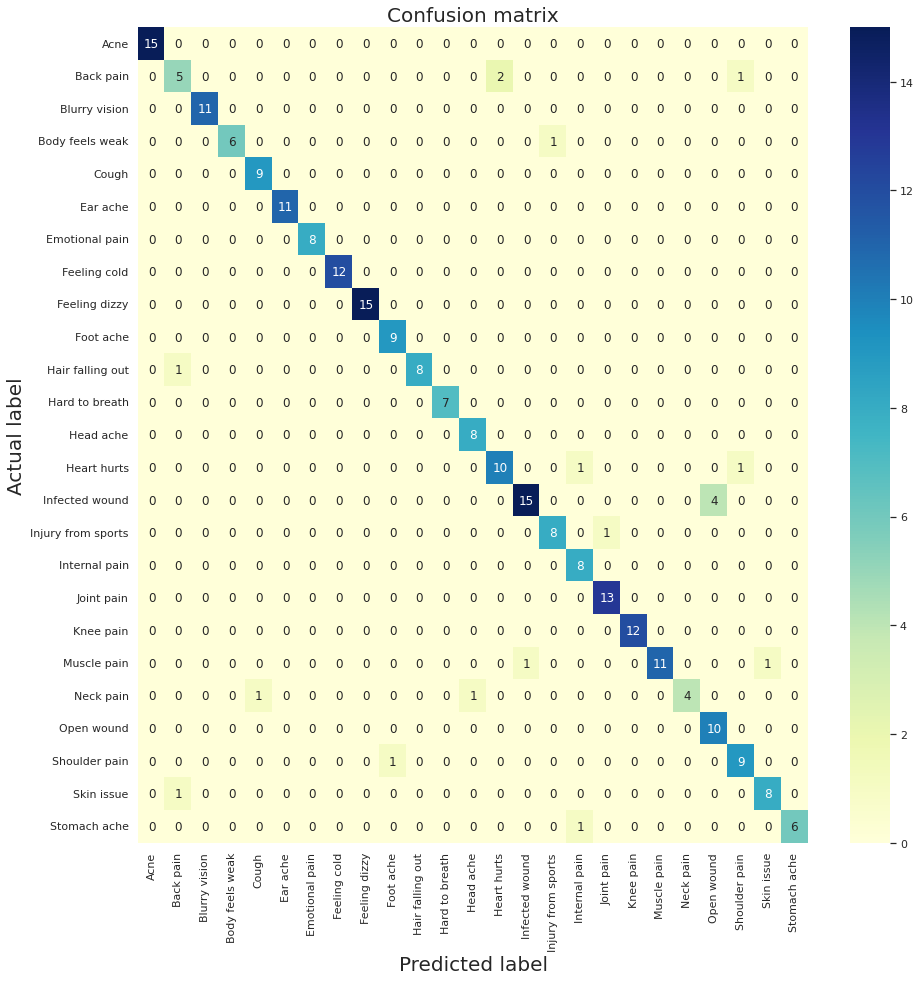

In [41]:
score_in_details()